# Super Rough gLV Code 
To be cleaned up

In [8]:
import numpy as np
from typing import Optional, Sequence, Tuple, Union

Number = Union[float, int]
ArrayLike1 = Union[Number, Sequence[Number], np.ndarray]

def _to_array(x: ArrayLike1, shape: Tuple[int, ...]) -> np.ndarray:
    arr = np.asarray(x)
    if arr.ndim == 0:
        return np.broadcast_to(arr, shape).astype(float)
    if arr.ndim == 1 and arr.shape[0] == shape[0]:
        return np.broadcast_to(arr.reshape(shape[0], *([1] * (len(shape)-1))), shape).astype(float)
    try:
        return np.broadcast_to(arr, shape).astype(float)
    except Exception:
        raise ValueError(f"Cannot broadcast {x} to shape {shape}")

def generate_gaussian_params_with_diag(
    n_species: int,
    vec_mean: ArrayLike1 = 0.0,
    vec_std: ArrayLike1 = 1.0,
    vec_bounds: Tuple[Number, Number] = (-np.inf, np.inf),
    mat_mean: ArrayLike1 = 0.0,
    mat_std: ArrayLike1 = 1.0,
    mat_bounds: Tuple[Number, Number] = (-np.inf, np.inf),
    diag_mean: ArrayLike1 = 0.0,
    diag_std: ArrayLike1 = 1.0,
    diag_bounds: Tuple[Number, Number] = (-np.inf, np.inf),
    seed: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate:
      1) a numpy vector of shape (n_species,)
      2) a numpy matrix of shape (n_species, n_species)

    Differences from previous version:
      - matrix diagonal entries are sampled with (diag_mean, diag_std) and clipped to diag_bounds
      - off-diagonal entries are sampled with (mat_mean, mat_std) and clipped to mat_bounds

    Parameters follow same broadcasting rules as before:
      - scalar, 1-D length n_species (applied per-row), or full 2-D (n_species x n_species) for mat_mean/mat_std
      - diag_mean/diag_std can be scalar or 1-D length n_species (per-diagonal) or 1-D broadcastable to diagonal
    """
    if n_species <= 0:
        raise ValueError("n_species must be a positive integer.")

    rng = np.random.default_rng(seed)

    # Vector
    vec_shape = (n_species,)
    v_mean = _to_array(vec_mean, vec_shape)
    v_std = _to_array(vec_std, vec_shape)
    if np.any(v_std < 0):
        raise ValueError("Vector std must be non-negative.")
    v = rng.normal(loc=v_mean, scale=v_std, size=vec_shape)
    v = np.clip(v, vec_bounds[0], vec_bounds[1])

    # Matrix: prepare shapes
    mat_shape = (n_species, n_species)

    # Off-diagonal mean/std -> accept scalar, 1-D (len n_species -> broadcast to rows), or full 2-D
    mat_mean_arr = np.asarray(mat_mean)
    mat_std_arr = np.asarray(mat_std)

    if mat_mean_arr.ndim == 0:
        mat_mean_full = np.broadcast_to(mat_mean_arr, mat_shape).astype(float)
    elif mat_mean_arr.ndim == 1:
        if mat_mean_arr.shape[0] == n_species:
            mat_mean_full = np.broadcast_to(mat_mean_arr.reshape(n_species, 1), mat_shape).astype(float)
        else:
            raise ValueError("1-D mat_mean must have length n_species.")
    elif mat_mean_arr.shape == mat_shape:
        mat_mean_full = mat_mean_arr.astype(float)
    else:
        raise ValueError("mat_mean must be scalar, 1-D of length n_species, or 2-D (n_species x n_species).")

    if mat_std_arr.ndim == 0:
        mat_std_full = np.broadcast_to(mat_std_arr, mat_shape).astype(float)
    elif mat_std_arr.ndim == 1:
        if mat_std_arr.shape[0] == n_species:
            mat_std_full = np.broadcast_to(mat_std_arr.reshape(n_species, 1), mat_shape).astype(float)
        else:
            raise ValueError("1-D mat_std must have length n_species.")
    elif mat_std_arr.shape == mat_shape:
        mat_std_full = mat_std_arr.astype(float)
    else:
        raise ValueError("mat_std must be scalar, 1-D of length n_species, or 2-D (n_species x n_species).")

    if np.any(mat_std_full < 0):
        raise ValueError("Matrix std must be non-negative.")

    # Diagonal mean/std -> accept scalar or 1-D length n_species
    diag_mean_arr = np.asarray(diag_mean)
    diag_std_arr = np.asarray(diag_std)

    if diag_mean_arr.ndim == 0:
        diag_mean_vec = np.full((n_species,), float(diag_mean_arr))
    elif diag_mean_arr.ndim == 1 and diag_mean_arr.shape[0] == n_species:
        diag_mean_vec = diag_mean_arr.astype(float)
    else:
        raise ValueError("diag_mean must be scalar or 1-D array of length n_species.")

    if diag_std_arr.ndim == 0:
        diag_std_vec = np.full((n_species,), float(diag_std_arr))
    elif diag_std_arr.ndim == 1 and diag_std_arr.shape[0] == n_species:
        diag_std_vec = diag_std_arr.astype(float)
    else:
        raise ValueError("diag_std must be scalar or 1-D array of length n_species.")

    if np.any(diag_std_vec < 0):
        raise ValueError("Diagonal std must be non-negative.")

    # Sample full matrix for off-diagonals first
    M = rng.normal(loc=mat_mean_full, scale=mat_std_full, size=mat_shape)
    M = np.clip(M, mat_bounds[0], mat_bounds[1])

    # Replace diagonal with samples from diagonal distribution and apply diag bounds
    diag_samples = rng.normal(loc=diag_mean_vec, scale=diag_std_vec, size=(n_species,))
    diag_samples = np.clip(diag_samples, diag_bounds[0], diag_bounds[1])
    np.fill_diagonal(M, diag_samples)

    return v, M


In [35]:
import numpy as np

# Example usage
n_species = 5

vec, mat = generate_gaussian_params_with_diag(
    n_species=n_species,
    vec_mean=0.7,
    vec_std=0.5,
    vec_bounds=(0.4, 1.5),
    mat_mean=0.0,          # off-diagonal mean
    mat_std=0.5,           # off-diagonal std
    mat_bounds=(-1.5, 1.0),
    diag_mean=-1.7,         # diagonal mean
    diag_std=0.5,         # diagonal std
    diag_bounds=(-3.0, -1.0),
    seed=123
)

np.set_printoptions(precision=4, suppress=True)

print("Vector (shape {}):".format(vec.shape))
print(vec)

print("\nMatrix (shape {}):".format(mat.shape))
print(mat)


Vector (shape (5,)):
[0.4    0.5161 1.344  0.797  1.1601]

Matrix (shape (5, 5)):
[[-1.8809 -0.3182  0.271  -0.1583 -0.1612]
 [ 0.0486 -2.3151  0.5961 -0.3355  0.5001]
 [ 0.0682  0.766  -1.0869 -0.1559  0.1689]
 [-1.1037  0.414   0.7708 -2.786   0.3774]
 [-0.073   0.641   0.537   0.1963 -1.8851]]


In [36]:
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional

def generate_community_dataframe(
    n_species: int,
    size_counts: List[Tuple[int, int]],
    mean_abundance: float = 0.01,
    bounds: Tuple[float, float] = (0.001, 0.1),
    sigma_log: float = 1.0,
    seed: Optional[int] = None,
    time_value: int = 0,
    comm_name_prefix: str = "comm",
) -> pd.DataFrame:
    """
    Generate a dataframe with columns: Comm_name, Time, sp1, sp2, ..., spN.

    Parameters
    ----------
    n_species
        Number of possible species (columns sp1..spN).
    size_counts
        List of tuples (community_size, n_communities). Example: [(1,5),(2,10),(3,12)].
        Interpretation: produce n_communities communities that contain exactly community_size
        non-zero species (the remaining species have abundance 0).
    mean_abundance
        Desired mean abundance of the lognormal distribution (in original space).
    bounds
        (low, high) inclusive clipping bounds for abundances.
    sigma_log
        Standard deviation of the underlying normal used by numpy.lognormal.
        mu is computed so that the lognormal's mean (exp(mu + sigma^2/2)) equals mean_abundance.
    seed
        RNG seed for reproducibility.
    time_value
        Value to place in the Time column for every row (scalar).
    comm_name_prefix
        Prefix used to name communities: e.g. comm1, comm2, ...

    Behavior notes
    --------------
    - Special rule for size==1 communities:
      the function enforces a minimum of n_species such communities. The first n_species
      of them will sample each species exactly once (so every species appears once).
      Any additional size==1 communities are assigned species at random with replacement.
    - For size>1 communities species are chosen uniformly at random without replacement.
    - Abundances for present species are sampled from the lognormal described above and
      clipped to `bounds`. Absent species have abundance 0.0.
    """
    if n_species <= 0:
        raise ValueError("n_species must be > 0.")
    if bounds[0] < 0 or bounds[1] <= 0:
        raise ValueError("bounds must be positive and bounds[0] < bounds[1].")
    if mean_abundance <= 0:
        raise ValueError("mean_abundance must be positive.")
    if sigma_log <= 0:
        raise ValueError("sigma_log must be positive.")

    rng = np.random.default_rng(seed)

    # Prepare mu for numpy.lognormal such that E[X] = mean_abundance:
    # mean_abundance = exp(mu + sigma^2 / 2)  => mu = log(mean_abundance) - sigma^2/2
    mu_log = np.log(mean_abundance) - 0.5 * (sigma_log ** 2)
    low, high = bounds

    rows = []
    comm_counter = 1

    # Convert input to a dict for easier handling and to ensure deterministic ordering by size
    size_to_count = {int(sz): int(cnt) for sz, cnt in size_counts}
    sizes_sorted = sorted(size_to_count.keys())

    for size in sizes_sorted:
        count = size_to_count[size]
        if size < 1 or size > n_species:
            raise ValueError(f"community size must be in [1, n_species]. Invalid: {size}")

        if size == 1:
            # enforce minimum of n_species
            if count < n_species:
                count = n_species

            # first ensure each species is sampled exactly once
            # produce n_species communities each with a unique species
            for i in range(n_species):
                species_present = [i]  # index i present
                abundances = np.zeros(n_species, dtype=float)
                sampled = rng.lognormal(mean=mu_log, sigma=sigma_log, size=1)[0]
                sampled = float(np.clip(sampled, low, high))
                abundances[i] = sampled
                rows.append((f"{comm_name_prefix}{comm_counter}", time_value, abundances))
                comm_counter += 1

            # if there are extra (count - n_species) communities, pick species at random with replacement
            extras = count - n_species
            for _ in range(extras):
                i = rng.integers(0, n_species)
                abundances = np.zeros(n_species, dtype=float)
                sampled = rng.lognormal(mean=mu_log, sigma=sigma_log, size=1)[0]
                sampled = float(np.clip(sampled, low, high))
                abundances[i] = sampled
                rows.append((f"{comm_name_prefix}{comm_counter}", time_value, abundances))
                comm_counter += 1

        else:
            # size > 1
            for _ in range(count):
                # choose `size` species without replacement
                species_present = rng.choice(n_species, size=size, replace=False)
                abundances = np.zeros(n_species, dtype=float)
                # sample one abundance per present species
                sampled = rng.lognormal(mean=mu_log, sigma=sigma_log, size=size)
                sampled = np.clip(sampled, low, high).astype(float)
                abundances[species_present] = sampled
                rows.append((f"{comm_name_prefix}{comm_counter}", time_value, abundances))
                comm_counter += 1

    # Build DataFrame
    # Columns: Comm_name, Time, sp1..spN
    col_names = ["Comm_name", "Time"] + [f"sp{i+1}" for i in range(n_species)]
    data = []
    for comm_name, tval, abundances in rows:
        row = [comm_name, tval] + abundances.tolist()
        data.append(row)

    df = pd.DataFrame(data, columns=col_names)
    return df



In [37]:

n_species = 5
size_counts = [(1, 3), (2, 4), (3, 2)]  # example: will enforce at least 5 communities for size==1
df = generate_community_dataframe(
    n_species=n_species,
    size_counts=size_counts,
    mean_abundance=0.01,
    bounds=(0.001, 0.1),
    sigma_log=1.0,
    seed=42,
    time_value=0,
    comm_name_prefix="comm"
)

pd.options.display.float_format = "{:.6f}".format
print(df)

   Comm_name  Time      sp1      sp2      sp3      sp4      sp5
0      comm1     0 0.008226 0.000000 0.000000 0.000000 0.000000
1      comm2     0 0.000000 0.002144 0.000000 0.000000 0.000000
2      comm3     0 0.000000 0.000000 0.012846 0.000000 0.000000
3      comm4     0 0.000000 0.000000 0.000000 0.015536 0.000000
4      comm5     0 0.000000 0.000000 0.000000 0.000000 0.001000
5      comm6     0 0.000000 0.000000 0.004421 0.000000 0.005964
6      comm7     0 0.000000 0.000000 0.000000 0.013202 0.014614
7      comm8     0 0.000000 0.000000 0.000000 0.002568 0.009680
8      comm9     0 0.014600 0.000000 0.000000 0.002325 0.000000
9     comm10     0 0.020597 0.000000 0.005197 0.000000 0.003952
10    comm11     0 0.008741 0.009164 0.000000 0.009332 0.000000


In [38]:
import numpy as np
import pandas as pd
from typing import Sequence
from scipy.integrate import solve_ivp

def _validate_r_A(r: np.ndarray, A: np.ndarray):
    r = np.asarray(r, dtype=float)
    A = np.asarray(A, dtype=float)
    if r.ndim != 1:
        raise ValueError("r must be a 1-D array of length n_species.")
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square (n_species x n_species) matrix.")
    if A.shape[0] != r.shape[0]:
        raise ValueError("r and A dimension mismatch.")
    return r, A

def simulate_gLV_dataframe(
    df_init: pd.DataFrame,
    r: Sequence[float],
    A: Sequence[Sequence[float]],
    timepoints: np.ndarray,
    species_prefix: str = "sp",
    atol: float = 1e-8,
    rtol: float = 1e-6,
    enforce_nonnegative: bool = True,
) -> pd.DataFrame:
    """
    Simulate gLV dynamics for each community present in `df_init`.

    Arguments
    ---------
    df_init
        DataFrame containing initial rows for each community. Must include columns:
        "Comm_name", "Time", and species columns named f"{species_prefix}1"...f"{species_prefix}N".
        It is assumed df_init contains at least one row per community (initial condition).
    r
        1-D array (length n_species) of intrinsic growth rates.
    A
        2-D array (n_species x n_species) of interaction coefficients (A_ij multiplies x_j in dx_i/dt).
    timepoints
        1-D numpy array of timepoints (increasing) at which to produce outputs (e.g., np.linspace(0, T, m)).
        The first timepoint is treated as the initial time. The initial state for each community is read
        from df_init at that initial time (if present) or the earliest time for that community in df_init.
    species_prefix
        Prefix for species columns; columns are expected to be species_prefix + index (1-indexed).
    atol, rtol
        Solver tolerances forwarded to scipy.integrate.solve_ivp.
    enforce_nonnegative
        If True, abundances are clipped to >= 0 after integration.

    Returns
    -------
    df_out
        DataFrame with rows for every community and every time in `timepoints`.
        Columns: Comm_name, Time, sp1, sp2, ..., spN
    """
    if timepoints.ndim != 1:
        raise ValueError("timepoints must be a 1-D numpy array.")
    if len(timepoints) < 2:
        raise ValueError("timepoints should contain at least 2 values (start and end).")

    r, A = _validate_r_A(np.asarray(r), np.asarray(A))
    n_species = r.shape[0]

    # Construct species column names and validate df_init contains them
    species_cols = [f"{species_prefix}{i+1}" for i in range(n_species)]
    required_cols = {"Comm_name", "Time"} | set(species_cols)
    missing = required_cols - set(df_init.columns)
    if missing:
        raise ValueError(f"df_init is missing required columns: {missing}")

    # Prepare output rows
    out_rows = []
    comm_names = df_init["Comm_name"].unique()

    t0 = float(timepoints[0])
    t_final = float(timepoints[-1])

    # Define derivative: dx/dt = x * (r + A @ x)
    def glv_rhs(t, x):
        # Use elementwise multiplication: x * (r + A x)
        # ensure small negative/NaN values don't explode the solver:
        x_pos = x
        # if solver ever passes NaNs, guard:
        if np.any(np.isnan(x_pos)):
            x_pos = np.nan_to_num(x_pos, nan=0.0)
        return x_pos * (r + A.dot(x_pos))

    for comm in comm_names:
        # Find the row to use as initial state:
        df_comm = df_init[df_init["Comm_name"] == comm]
        if df_comm.empty:
            continue
        # Prefer a row at the requested initial timepoint if exists, else use the earliest row for that comm.
        # Compare floats carefully: allow exact match first.
        match_rows = df_comm[np.isclose(df_comm["Time"].astype(float), t0)]
        if len(match_rows) > 0:
            init_row = match_rows.iloc[0]
        else:
            init_row = df_comm.sort_values("Time").iloc[0]

        x0 = init_row[species_cols].to_numpy(dtype=float)
        # Clip negatives in initial condition
        if enforce_nonnegative:
            x0 = np.maximum(x0, 0.0)

        # If the initial state is all zeros, integration will remain zero; we still produce outputs.
        if np.allclose(x0, 0.0):
            # Add zero rows for every timepoint
            for t in timepoints:
                out_rows.append([comm, float(t), *([0.0] * n_species)])
            continue

        # Integrate
        sol = solve_ivp(
            fun=glv_rhs,
            t_span=(t0, t_final),
            y0=x0,
            t_eval=timepoints,
            method="RK45",
            atol=atol,
            rtol=rtol,
        )

        if not sol.success:
            # fallback: try with tighter tolerances or smaller max_step in a robust implementation.
            # Here we raise an informative error.
            raise RuntimeError(f"ODE solver failed for community {comm}: {sol.message}")

        X = sol.y.T  # shape (len(timepoints), n_species)

        if enforce_nonnegative:
            X = np.maximum(X, 0.0)

        # Append rows
        for idx, t in enumerate(timepoints):
            out_rows.append([comm, float(t), *X[idx].tolist()])

    # Build DataFrame
    columns = ["Comm_name", "Time"] + species_cols
    df_out = pd.DataFrame(out_rows, columns=columns)

    # Sort rows by Comm_name then Time for readability
    df_out = df_out.sort_values(["Comm_name", "Time"]).reset_index(drop=True)

    return df_out

In [43]:
# Create timepoints
timepoints = np.linspace(0.0, 20.0, 21)

# Use the previously created `vec`, `mat`, and `df` variables
# (replace these example lines with your actual variables)
try:
    vec  # type: ignore
    mat  # type: ignore
    df  # type: ignore
except NameError:
    # demo fallback: create toy r, A, df for the example to run
    n_species = 5
    # weak self-regulation on diagonal, small off-diagonal interactions
    rng = np.random.default_rng(123)
    vec = np.full(n_species, 0.5)  # intrinsic growth rates
    mat = -0.1 * np.eye(n_species) + 0.02 * rng.normal(size=(n_species, n_species))
    # create a tiny df with two communities (this is only a demo)
    df = pd.DataFrame([
        ["comm1", 0.0, 0.01, 0.00, 0.00, 0.00, 0.00],
        ["comm2", 0.0, 0.00, 0.02, 0.03, 0.00, 0.00],
    ], columns=["Comm_name", "Time"] + [f"sp{i+1}" for i in range(n_species)])

# Run simulation
df_sim = simulate_gLV_dataframe(df_init=df, r=vec, A=mat, timepoints=timepoints)

# Print a small sample
pd.set_option("display.precision", 6)
df_sim


,Comm_name,Time,sp1,sp2,sp3,sp4,sp5
0,comm1,0.000000,0.008226,0.000000,0.000000,0.000000,0.000000
1,comm1,1.000000,0.012043,0.000000,0.000000,0.000000,0.000000
2,comm1,2.000000,0.017479,0.000000,0.000000,0.000000,0.000000
3,comm1,3.000000,0.025062,0.000000,0.000000,0.000000,0.000000
4,comm1,4.000000,0.035340,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
226,comm9,16.000000,0.189484,0.000000,0.000000,0.212895,0.000000
227,comm9,17.000000,0.191082,0.000000,0.000000,0.211885,0.000000
228,comm9,18.000000,0.192229,0.000000,0.000000,0.211092,0.000000
229,comm9,19.000000,0.193049,0.000000,0.000000,0.210484,0.000000


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union, Sequence, Optional, Tuple
from scipy.integrate import solve_ivp

def _select_communities(all_names: np.ndarray, selector: Union[int, Sequence[str]]) -> np.ndarray:
    if isinstance(selector, (list, tuple, np.ndarray)):
        requested = list(selector)
        present = [c for c in requested if c in all_names]
        return np.array(present, dtype=object)
    if isinstance(selector, int):
        n_all = len(all_names)
        if selector == 0:
            return np.array([], dtype=object)
        if selector > 0:
            return all_names[:min(selector, n_all)]
        l = abs(selector)
        return all_names[max(0, n_all - l): n_all]
    return all_names

def _glv_integrate(r: np.ndarray, A: np.ndarray, x0: np.ndarray, timepoints: np.ndarray,
                   atol: float = 1e-8, rtol: float = 1e-6) -> np.ndarray:
    r = np.asarray(r, dtype=float)
    A = np.asarray(A, dtype=float)
    x0 = np.asarray(x0, dtype=float)
    if r.ndim != 1:
        raise ValueError("r must be 1-D array.")
    if A.ndim != 2 or A.shape[0] != A.shape[1] or A.shape[0] != r.shape[0]:
        raise ValueError("A must be square and match the length of r.")
    if x0.shape[0] != r.shape[0]:
        raise ValueError("x0 length must match r length.")

    def rhs(t, x):
        x_safe = np.nan_to_num(x, nan=0.0)
        return x_safe * (r + A.dot(x_safe))

    sol = solve_ivp(fun=rhs,
                    t_span=(float(timepoints[0]), float(timepoints[-1])),
                    y0=x0, t_eval=timepoints, method="RK45",
                    atol=atol, rtol=rtol)
    if not sol.success:
        raise RuntimeError(f"ODE solver failed: {sol.message}")
    X = sol.y.T
    X[X < 0] = 0.0
    return X

def plot_community_dynamics(
    df: pd.DataFrame,
    communities: Union[int, Sequence[str]] = 5,
    r: Optional[Sequence[float]] = None,
    A: Optional[Sequence[Sequence[float]]] = None,
    sim_timepoints: Optional[np.ndarray] = None,
    species_prefix: str = "sp",
    per_row_figsize: Tuple[float, float] = (10.0, 2.5),
    line_width: float = 1.5,
    data_marker_size: int = 50,
    sim_line_alpha: float = 0.9,
    data_marker_alpha: float = 0.9,
    legend_loc: str = "upper right",
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Plot communities from a dataframe produced by simulate_gLV_dataframe (or similar).

    Behavior:
      - If r and A are provided: for each selected community simulate full gLV dynamics
        starting from that community's earliest-row abundances used as x0 at time 0.
        Plot dense simulation lines and overlay dataframe timepoints as markers only
        (no connecting lines between dataframe points).
      - If r or A is missing: plot the dataframe trajectories as connected lines.
      - communities selection semantics: positive int => first l; negative int => last l;
        list of names => those in given order (filtered to existing).
    """
    if "Comm_name" not in df.columns or "Time" not in df.columns:
        raise ValueError("df must contain 'Comm_name' and 'Time' columns.")

    species_cols = [c for c in df.columns if c.startswith(species_prefix)]
    if len(species_cols) == 0:
        raise ValueError(f"No species columns found with prefix '{species_prefix}'.")
    n_species = len(species_cols)

    all_comm_names = df["Comm_name"].astype(str).unique()
    selected = _select_communities(all_comm_names, communities)
    if selected.size == 0:
        raise ValueError("No communities selected (empty selection).")

    do_sim = (r is not None) and (A is not None)
    if do_sim:
        r = np.asarray(r, dtype=float)
        A = np.asarray(A, dtype=float)
        if r.shape[0] != n_species:
            raise ValueError("Length of r must equal number of species columns.")
        if A.shape != (n_species, n_species):
            raise ValueError("A must be shape (n_species, n_species).")

    # Default dense sim timepoints if sim requested
    if do_sim:
        if sim_timepoints is None:
            max_t = float(df["Time"].astype(float).max())
            if max_t <= 0:
                max_t = 10.0
            sim_timepoints = np.linspace(0.0, max_t, 500)
        else:
            sim_timepoints = np.asarray(sim_timepoints, dtype=float)
            if sim_timepoints.ndim != 1 or sim_timepoints.size < 2:
                raise ValueError("sim_timepoints must be a 1-D array with >= 2 entries.")

    n_plots = len(selected)
    fig = plt.figure(figsize=(per_row_figsize[0], per_row_figsize[1] * n_plots))
    axes = np.empty(n_plots, dtype=object)

    # get distinct colors for species from matplotlib color cycle
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', None)
    if color_cycle is None:
        color_cycle = plt.rcParams['axes.prop_cycle']()

    for idx, comm in enumerate(selected):
        ax = fig.add_subplot(n_plots, 1, idx + 1)
        axes[idx] = ax

        df_comm = df[df["Comm_name"] == comm].copy()
        if df_comm.empty:
            ax.set_title(f"{comm} (no data)", loc="left")
            ax.set_xlabel("Time")
            ax.set_ylabel("Abundance")
            continue

        df_comm["Time"] = df_comm["Time"].astype(float)
        earliest_row = df_comm.sort_values("Time").iloc[0]
        x0 = earliest_row[species_cols].to_numpy(dtype=float)

        # determine colors for species (repeat if fewer colors than species)
        if isinstance(color_cycle, dict):
            base_colors = color_cycle.get('color', None)
        else:
            base_colors = color_cycle
        colors = (base_colors * ((n_species // len(base_colors)) + 1))[:n_species] if base_colors else None

        # MODE 1: parameters provided -> full simulation lines + dataframe markers only
        if do_sim:
            try:
                Xsim = _glv_integrate(r=r, A=A, x0=x0, timepoints=sim_timepoints)
            except Exception as e:
                raise RuntimeError(f"Simulation failed for community {comm}: {e}")

            # plot simulated continuous trajectories (dense)
            for s_i, col in enumerate(species_cols):
                if colors is not None:
                    ax.plot(sim_timepoints, Xsim[:, s_i],
                            linewidth=line_width, alpha=sim_line_alpha,
                            color=colors[s_i])
                else:
                    ax.plot(sim_timepoints, Xsim[:, s_i],
                            linewidth=line_width, alpha=sim_line_alpha)

            # mark simulation start (one cross per species) using same colors
            x_start = sim_timepoints[0]
            y_start = Xsim[0, :]
            if colors is not None:
                for s_i in range(n_species):
                    ax.scatter(x_start, y_start[s_i], marker="x",
                               s=max(6, data_marker_size // 3),
                               color=colors[s_i], zorder=5)
            else:
                ax.scatter(np.full(n_species, x_start), y_start, marker="x",
                           s=max(6, data_marker_size // 3), zorder=5)

            # overlay dataframe points as markers only (no lines), colored per species
            times_data = df_comm["Time"].to_numpy(dtype=float)
            for s_i, col in enumerate(species_cols):
                y_data = df_comm[col].to_numpy(dtype=float)
                if colors is not None:
                    ax.scatter(times_data, y_data,
                               s=data_marker_size, alpha=data_marker_alpha,
                               color=colors[s_i], label=col if idx == 0 else None, zorder=4)
                else:
                    ax.scatter(times_data, y_data,
                               s=data_marker_size, alpha=data_marker_alpha,
                               label=col if idx == 0 else None, zorder=4)

            x_min_plot, x_max_plot = sim_timepoints[0], sim_timepoints[-1]
            y_all = np.concatenate([Xsim.ravel(), df_comm[species_cols].to_numpy().ravel()])

        else:
            # MODE 2: no parameters -> plot dataframe trajectories as connected lines
            times_data = df_comm["Time"].to_numpy(dtype=float)
            for s_i, col in enumerate(species_cols):
                y_data = df_comm[col].to_numpy(dtype=float)
                if colors is not None:
                    ax.plot(times_data, y_data, linewidth=line_width, alpha=sim_line_alpha,
                            color=colors[s_i], label=col if idx == 0 else None)
                else:
                    ax.plot(times_data, y_data, linewidth=line_width, alpha=sim_line_alpha,
                            label=col if idx == 0 else None)
            x_min_plot, x_max_plot = times_data.min(), times_data.max()
            y_all = df_comm[species_cols].to_numpy().ravel()

        ax.set_title(f"{comm}", loc="left")
        ax.set_xlabel("Time")
        ax.set_ylabel("Abundance")
        ax.set_xlim(left=x_min_plot, right=x_max_plot)

        if np.allclose(y_all, 0.0):
            ax.set_ylim(0.0, 1.0)
        else:
            ypos = y_all[y_all > 0.0] if np.any(y_all > 0.0) else y_all
            y_min = float(np.min(ypos))
            y_max = float(np.max(ypos))
            pad = 0.1 * (y_max - y_min) if y_max > y_min else 0.1 * max(y_max, 1.0)
            ax.set_ylim(max(0.0, y_min - pad), y_max + pad)

        if idx == 0:
            # build legend showing species labels
            handles = []
            labels = []
            for s_i, col in enumerate(species_cols):
                line, = ax.plot([], [], linewidth=line_width, color=(colors[s_i] if colors is not None else None))
                handles.append(line)
                labels.append(col)
            ax.legend(handles, labels, loc=legend_loc, ncol=min(3, len(species_cols)))

        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

    plt.tight_layout()
    return fig, axes


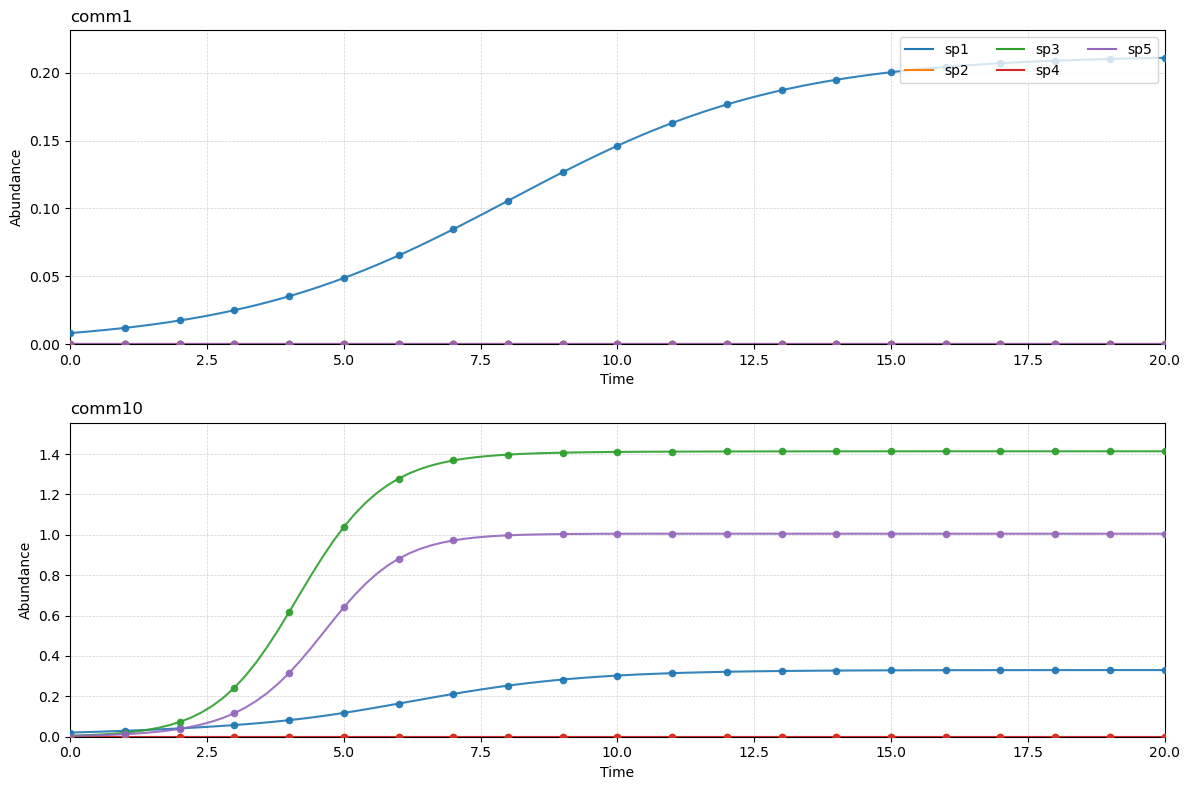

In [45]:
timepoints2 = np.linspace(0.0, 20.0, 101)

# Plot first 2 communities
fig, axes = plot_community_dynamics(df=df_sim, communities=2, r=vec, A=mat,
                                    sim_timepoints=timepoints2,
                                    per_row_figsize=(12, 4),
                                    data_marker_size=20)
plt.show()


In [ ]:
df_sim.to_csv('test_data/test5sp.csv', index=False)